In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil as sh
import os
import time
import random

print(f"Cuda available: {torch.cuda.is_available()}")

Cuda available: True


In [3]:
img_size = 224

# Autoencoder stuff
batch_size = 32
learning_rate = 1e-3
num_epochs = 30
dropout = 0.1
convolutional_kernel = 4
max_pool_kernel = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

workers = os.cpu_count() - 2
print(f"Using {workers} workers for loading the datasets")

Using device cuda:0
Using 14 workers for loading the datasets


In [46]:
def preprocess(org_path: str, train: bool):
    arr = org_path.split("/")
    dst_start = "/".join(arr[:arr.index("Datasets") + 1])
    dst = ""
    if train:
        dst = dst_start + "/Cleaned2/train/" + "/".join(org_path.split("/")[-2:])
    else:
        dst = dst_start + "/Cleaned2/validate/" + "/".join(org_path.split("/")[-2:])

    if not (dst.endswith(".jpg") or dst.endswith(".jpeg")):
        dst = ".".join(dst.split(".")[:-1]) + ".jpg"

    if os.path.exists(dst):
        print("File already preprocessed")
        return

    image = Image.open(org_path)
    image = image.resize((img_size, img_size), Image.Resampling.HAMMING)

    if image.mode in ("RGBA", "LA"): #If the image has transparency, get rid of it
        background = Image.new("RGB", image.size, (255, 255, 255)) #Create a white image to act as the background
        background.paste(image, mask=image.split()[3]) #Apply this background where there is transparency on the image
        image = background

    os.makedirs("/".join(dst.split("/")[:-1]), exist_ok=True)
    image.save(dst, "JPEG")     

In [47]:
try:
    for dirPath, _, files in os.walk("./Datasets/Tipical_Brazilian_Foods/train/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, True)

    for dirPath, _, files in os.walk("./Datasets/Tipical_Brazilian_Foods/valid/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, False)
except FileNotFoundError:
    print("Couldn't find and image. Problably the dataset doesn't exist or its path is wrong")

File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already

In [48]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.RandomRotation(30),      # Rotaciones aleatorias de hasta 30 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios en color
    transforms.ToTensor()
])

transform_validation = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ImageFolder('./Datasets/Cleaned2/train', transform=transform_train)
validation_dataset = ImageFolder('./Datasets/Cleaned2/validate', transform=transform_train)

classes = ["Acaraje", "Arroz_com_pequi", "Arroz_de_Cuxa", "Barreado", "Churrasco", "Eisben", "Feijoada", "Matrinxa", "Moqueca_capixaba", "Pao_de_queijo", "Pato_no_Tucupi", "Tacaca"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
dataloaders = {"train": train_loader, "validate": validation_loader}

In [49]:
import logging

logging.basicConfig(level=logging.INFO)

class Print(nn.Module):
    def __init__(self, msg: str):
        super().__init__()
        self.msg = msg

    def forward(self, original_tensor: torch.Tensor) -> torch.Tensor:
        # print(self.msg)
        logging.info(self.msg)
        return original_tensor

In [4]:
class Classificator(nn.Module):
    def __init__(self):
        super(Classificator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=convolutional_kernel, stride=1, padding=2),
            nn.MaxPool2d(max_pool_kernel),
            # nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.Dropout(dropout),

            nn.Conv2d(64, 128, kernel_size=convolutional_kernel, stride=1, padding=2),
            nn.MaxPool2d(max_pool_kernel),
            # nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.Dropout(dropout),

            nn.Conv2d(128, 256, kernel_size=convolutional_kernel, stride=1, padding=2),
            nn.MaxPool2d(max_pool_kernel),
            # nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.Dropout(dropout),
            
            nn.Conv2d(256, 512, kernel_size=convolutional_kernel, stride=1, padding=2),
            nn.MaxPool2d(max_pool_kernel),
            # nn.LazyBatchNorm2d(),
            nn.ReLU(),

            
            # nn.Dropout(dropout),

            nn.Flatten(),

            nn.Linear(512 * 14 * 14, 512),
            # nn.Dropout(dropout),
            nn.Linear(512, len(classes))
            # nn.Softmax()
        )

    def forward(self, x):
        return self.layers(x)

Epoch 0/29
----------


train phase: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it, Loss=2.37e+3, Accuracy=0.13%]


train Loss: 9.9362 Acc: 0.1088


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s, Loss=130, Accuracy=0.00%] 


validate Loss: 2.3634 Acc: 0.1455

Epoch finished at 0m 11s
Epoch 1/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=573, Accuracy=0.27%] 


train Loss: 2.3961 Acc: 0.1841


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s, Loss=131, Accuracy=0.48%] 


validate Loss: 2.3855 Acc: 0.2000

Epoch finished at 0m 21s
Epoch 2/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=569, Accuracy=0.20%] 


train Loss: 2.3799 Acc: 0.1883


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, Loss=130, Accuracy=0.48%]


validate Loss: 2.3550 Acc: 0.2000

Epoch finished at 0m 32s
Epoch 3/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=564, Accuracy=0.13%] 


train Loss: 2.3604 Acc: 0.2008


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, Loss=129, Accuracy=0.48%] 


validate Loss: 2.3401 Acc: 0.2000

Epoch finished at 0m 42s
Epoch 4/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=558, Accuracy=0.13%] 


train Loss: 2.3343 Acc: 0.1883


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, Loss=127, Accuracy=0.39%] 


validate Loss: 2.3003 Acc: 0.1636

Epoch finished at 0m 52s
Epoch 5/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=542, Accuracy=0.07%] 


train Loss: 2.2691 Acc: 0.2636


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, Loss=126, Accuracy=0.52%] 


validate Loss: 2.2848 Acc: 0.2364

Epoch finished at 1m 3s
Epoch 6/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=528, Accuracy=0.27%] 


train Loss: 2.2099 Acc: 0.2971


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, Loss=134, Accuracy=0.48%] 


validate Loss: 2.4354 Acc: 0.2364

Epoch finished at 1m 13s
Epoch 7/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=534, Accuracy=0.20%] 


train Loss: 2.2325 Acc: 0.2510


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, Loss=123, Accuracy=0.52%] 


validate Loss: 2.2283 Acc: 0.2545

Epoch finished at 1m 24s
Epoch 8/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=503, Accuracy=0.20%] 


train Loss: 2.1038 Acc: 0.3138


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s, Loss=120, Accuracy=0.17%] 


validate Loss: 2.1827 Acc: 0.2364

Epoch finished at 1m 34s
Epoch 9/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=505, Accuracy=0.33%] 


train Loss: 2.1149 Acc: 0.2762


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, Loss=117, Accuracy=0.48%]


validate Loss: 2.1354 Acc: 0.3091

Epoch finished at 1m 44s
Epoch 10/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=477, Accuracy=0.33%] 


train Loss: 1.9971 Acc: 0.3138


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s, Loss=125, Accuracy=0.39%] 


validate Loss: 2.2655 Acc: 0.2364

Epoch finished at 1m 55s
Epoch 11/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=472, Accuracy=0.33%] 


train Loss: 1.9758 Acc: 0.3515


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, Loss=113, Accuracy=0.43%] 


validate Loss: 2.0581 Acc: 0.2364

Epoch finished at 2m 5s
Epoch 12/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=436, Accuracy=0.40%] 


train Loss: 1.8235 Acc: 0.3724


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, Loss=122, Accuracy=0.43%] 


validate Loss: 2.2162 Acc: 0.3273

Epoch finished at 2m 16s
Epoch 13/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it, Loss=419, Accuracy=0.27%]


train Loss: 1.7535 Acc: 0.4059


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, Loss=124, Accuracy=0.43%] 


validate Loss: 2.2618 Acc: 0.2364

Epoch finished at 2m 26s
Epoch 14/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=422, Accuracy=0.27%] 


train Loss: 1.7650 Acc: 0.3808


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, Loss=123, Accuracy=0.57%]


validate Loss: 2.2330 Acc: 0.3091

Epoch finished at 2m 36s
Epoch 15/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=397, Accuracy=0.47%] 


train Loss: 1.6614 Acc: 0.4435


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s, Loss=110, Accuracy=0.70%] 


validate Loss: 1.9953 Acc: 0.4364

Epoch finished at 2m 47s
Epoch 16/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=342, Accuracy=0.67%] 


train Loss: 1.4289 Acc: 0.5105


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s, Loss=129, Accuracy=0.61%] 


validate Loss: 2.3438 Acc: 0.4182

Epoch finished at 2m 57s
Epoch 17/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=378, Accuracy=0.27%] 


train Loss: 1.5800 Acc: 0.4854


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s, Loss=108, Accuracy=0.61%] 


validate Loss: 1.9663 Acc: 0.4364

Epoch finished at 3m 8s
Epoch 18/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=314, Accuracy=0.53%] 


train Loss: 1.3134 Acc: 0.5649


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, Loss=107, Accuracy=0.57%] 


validate Loss: 1.9464 Acc: 0.4182

Epoch finished at 3m 18s
Epoch 19/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=296, Accuracy=0.73%] 


train Loss: 1.2390 Acc: 0.5858


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, Loss=111, Accuracy=0.57%] 


validate Loss: 2.0118 Acc: 0.4545

Epoch finished at 3m 28s
Epoch 20/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=270, Accuracy=0.53%] 


train Loss: 1.1305 Acc: 0.5816


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, Loss=126, Accuracy=0.70%] 


validate Loss: 2.2917 Acc: 0.4364

Epoch finished at 3m 39s
Epoch 21/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=346, Accuracy=0.40%] 


train Loss: 1.4465 Acc: 0.5356


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, Loss=89.2, Accuracy=0.57%]


validate Loss: 1.6224 Acc: 0.5455

Epoch finished at 3m 49s
Epoch 22/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=280, Accuracy=0.60%] 


train Loss: 1.1732 Acc: 0.6151


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s, Loss=107, Accuracy=0.65%] 


validate Loss: 1.9474 Acc: 0.4545

Epoch finished at 3m 60s
Epoch 23/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=261, Accuracy=0.67%] 


train Loss: 1.0930 Acc: 0.6192


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s, Loss=107, Accuracy=0.65%] 


validate Loss: 1.9424 Acc: 0.5273

Epoch finished at 4m 10s
Epoch 24/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=245, Accuracy=0.67%] 


train Loss: 1.0269 Acc: 0.6862


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, Loss=92.7, Accuracy=0.61%]


validate Loss: 1.6857 Acc: 0.5091

Epoch finished at 4m 21s
Epoch 25/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=207, Accuracy=0.67%] 


train Loss: 0.8660 Acc: 0.7322


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, Loss=106, Accuracy=0.61%] 


validate Loss: 1.9307 Acc: 0.5273

Epoch finished at 4m 31s
Epoch 26/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=234, Accuracy=0.53%] 


train Loss: 0.9811 Acc: 0.6444


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s, Loss=114, Accuracy=0.70%] 


validate Loss: 2.0661 Acc: 0.5091

Epoch finished at 4m 41s
Epoch 27/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=195, Accuracy=0.80%] 


train Loss: 0.8149 Acc: 0.7448


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s, Loss=90.3, Accuracy=0.57%]


validate Loss: 1.6412 Acc: 0.5273

Epoch finished at 4m 52s
Epoch 28/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=199, Accuracy=0.53%] 


train Loss: 0.8316 Acc: 0.7029


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s, Loss=96.3, Accuracy=0.65%]


validate Loss: 1.7508 Acc: 0.4909

Epoch finished at 5m 2s
Epoch 29/29
----------


train phase: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it, Loss=207, Accuracy=0.80%] 


train Loss: 0.8653 Acc: 0.7364


validate phase: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s, Loss=99.3, Accuracy=0.74%]


validate Loss: 1.8054 Acc: 0.5273

Epoch finished at 5m 13s


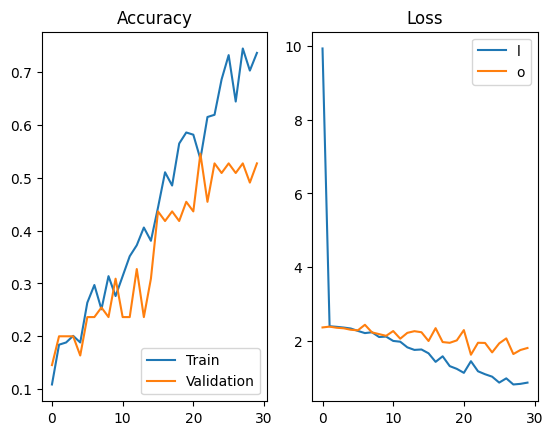

In [51]:
model = Classificator().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)


since = time.time()
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print("-"*10)

    for phase in ["train", "validate"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        with tqdm(total=len(dataloaders[phase]), desc=f"{phase} phase") as pbar:
            for inputs, labels, in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_acc = (torch.sum(preds == labels.data).item() / inputs.size(0))
                pbar.set_postfix({"Loss": running_loss, "Accuracy": f"{batch_acc:.2f}%"})
                pbar.update(1)


        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        # if phase == "validate":
        #     scheduler.step(epoch_loss)

        if phase == "train":
            train_acc.append(float(epoch_acc))
            train_loss.append(float(epoch_loss))
        else:
            val_acc.append(float(epoch_acc))
            val_loss.append(float(epoch_loss))

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        # print(f"LR: {scheduler.get_last_lr()[0]}")
    
    print()
    time_elapsed = time.time() - since
    print(f"Epoch finished at {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

torch.save(model.state_dict(), "Brazilian.pth")


plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label="Train")
plt.plot(range(len(val_acc)), val_acc, label="Validation")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label="Train")
plt.plot(range(len(val_loss)), val_loss, label="Validation")
plt.legend("lower right")
plt.title("Loss")

plt.show()

In [5]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

class ImagePredictor:
    def __init__(self, model_path, model_class, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
        # Initialize a new model instance
        self.model = model_class()
        # Load the saved state dict
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()  # Set to evaluation mode
        self.device = device
        self.model.to(device)
        
        # Store class names
        self.class_names = class_names
        
        # Define the same transforms used during training
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def predict_image(self, image_path):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0)  # Add batch dimension
        image_tensor = image_tensor.to(self.device)
        
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class_idx = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class_idx].item()
            
            # Get all probabilities as a list
            all_probs = probabilities[0].cpu().numpy()
            
            # Get predicted class name
            predicted_class_name = self.class_names[predicted_class_idx]
            
            # Create a list of (class_name, probability) tuples
            class_probabilities = [(class_name, prob) 
                                 for class_name, prob in zip(self.class_names, all_probs)]
            # Sort by probability in descending order
            class_probabilities.sort(key=lambda x: x[1], reverse=True)
            
        return {
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'all_predictions': class_probabilities
        }
    
    def predict_batch(self, image_paths):
        # Process multiple images at once
        batch_tensors = []
        for path in image_paths:
            image = Image.open(path).convert('RGB')
            tensor = self.transform(image)
            batch_tensors.append(tensor)
            
        batch = torch.stack(batch_tensors).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(batch)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_indices = torch.argmax(probabilities, dim=1).tolist()
            confidences = [probabilities[i][pred].item() for i, pred in enumerate(predicted_indices)]
            
            # Get predicted class names
            predicted_classes = [self.class_names[idx] for idx in predicted_indices]
            
        return list(zip(predicted_classes, confidences))

In [8]:
classes = ["Acaraje", "Arroz_com_pequi", "Arroz_de_Cuxa", "Barreado", "Churrasco", "Eisben", "Feijoada", "Matrinxa", "Moqueca_capixaba", "Pao_de_queijo", "Pato_no_Tucupi", "Tacaca"]

predictor = ImagePredictor(
    model_path='Brazilian.pth',
    model_class=Classificator,
    class_names=classes
)

# Single image prediction
result = predictor.predict_image('Predictions/Acaraje.jpg')
print(f"Predicted class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2f}")

# Print top 3 predictions
print("\nTop 3 predictions:")
for class_name, prob in result['all_predictions'][:3]:
    print(f"{class_name}: {prob:.2f}")

# Batch prediction
image_paths = ['Predictions/Churrasco.jpg', 'Predictions/Matrinxa.jpg', 'Predictions/Moqueca_capixaba.jpg', "Predictions/Tortilla.jpeg"]
predictions = predictor.predict_batch(image_paths)
for path, (pred_class, conf) in zip(image_paths, predictions):
    print(f"Image: {path}")
    print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

/tmp/ipykernel_1034/1451105881.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Predicted class: Acaraje
Confidence: 0.99

Top 3 predictions:
Acaraje: 0.99
Pao_de_queijo: 0.01
Barreado: 0.00
Image: Predictions/Churrasco.jpg
Predicted: Churrasco (confidence: 0.62)
Image: Predictions/Matrinxa.jpg
Predicted: Matrinxa (confidence: 0.62)
Image: Predictions/Moqueca_capixaba.jpg
Predicted: Moqueca_capixaba (confidence: 0.87)
Image: Predictions/Tortilla.jpeg
Predicted: Eisben (confidence: 0.63)
